<a href="https://colab.research.google.com/github/dawidhubicki97/ProjektAi/blob/main/Projekt_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

['MSFT', 'JPM', 'NKE', 'AMZN', 'AABA', 'INTC', 'GS', 'PG', 'MRK', 'IBM', 'BA', 'VZ', 'UNH', 'GE', 'JNJ', 'HD', 'MCD', 'AAPL', 'DIS', 'CSCO', 'KO', 'CVX', 'GOOGL', 'UTX', 'AXP', 'MMM', 'PFE', 'WMT', 'TRV', 'CAT', 'XOM']
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.91 µs
Fitting to NKE
Epoch 1/10
13/13 [==============================] - 16s 406ms/step - loss: 0.0627
Epoch 2/10
13/13 [==============================] - 5s 398ms/step - loss: 0.0077
Epoch 3/10
13/13 [==============================] - 5s 366ms/step - loss: 0.0108
Epoch 4/10
13/13 [==============================] - 5s 373ms/step - loss: 0.0093
Epoch 5/10
13/13 [==============================] - 5s 374ms/step - loss: 0.0101
Epoch 6/10
13/13 [==============================] - 5s 377ms/step - loss: 0.0071
Epoch 7/10
13/13 [==============================] - 5s 367ms/step - loss: 0.0062
Epoch 8/10
13/13 [==============================] - 5s 400ms/step - loss: 0.0081
Epoch 9/10
13/13 [==============================] - 5

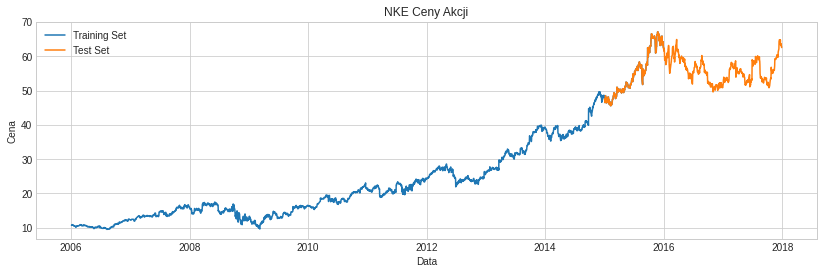

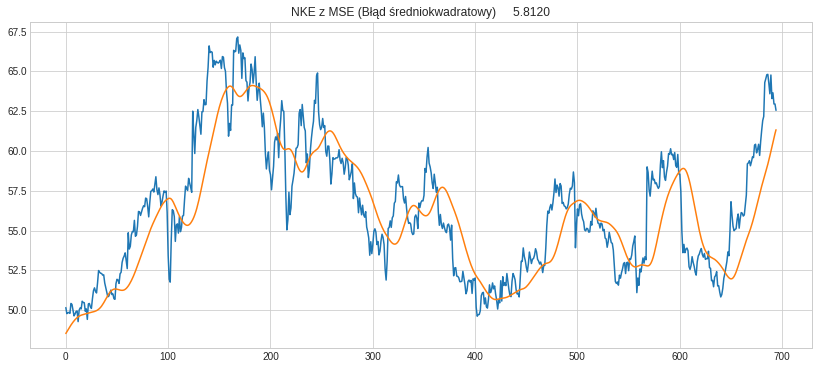

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
plt.style.use('seaborn-whitegrid')

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

# Wczytanie Danych
def returnRmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("Blad sredniokwadratowy to: {}.".format(rmse))

fileList = os.listdir("./inputdata")

companyList = []
for file in fileList:
    nameCompany = file.split("_")[0]
    if nameCompany != "all":
        companyList.append(nameCompany)
print(companyList)

stocksList = ["NKE"]
df = {}
for i in stocksList:
    df[i] = pd.read_csv("./inputdata/" + i + "_2006-01-01_to_2018-01-01.csv", index_col="Date", parse_dates=["Date"])

def split(dataframe, border, col):
    return dataframe.loc[:border,col], dataframe.loc[border:,col]

# Ceny do 2015 służą do treningu
dfNew = {}
for i in stocksList:
    dfNew[i] = {}
    dfNew[i]["Train"], dfNew[i]["Test"] = split(df[i], "2015", "Close")

# Narysowanie pierwszego wykresu
for i in stocksList:
    plt.figure(figsize=(14,4))
    plt.plot(dfNew[i]["Train"])
    plt.plot(dfNew[i]["Test"])
    plt.ylabel("Cena")
    plt.xlabel("Data")
    plt.legend(["Training Set", "Test Set"])
    plt.title(i + " Ceny Akcji")


transformTrain = {}
transformTest = {}
scaler = {}
#Reskalowanie cen akcji do skali 0-1
for num, i in enumerate(stocksList):
    sc = MinMaxScaler(feature_range=(0,1))
    a0 = np.array(dfNew[i]["Train"])
    a1 = np.array(dfNew[i]["Test"])
    a0 = a0.reshape(a0.shape[0],1)
    a1 = a1.reshape(a1.shape[0],1)
    transformTrain[i] = sc.fit_transform(a0)
    transformTest[i] = sc.fit_transform(a1)
    scaler[i] = sc
    
del a0
del a1


trainset = {}
testset = {}
for j in stocksList:
    trainset[j] = {}
    X_train = []
    y_train = []
    for i in range(60,2516):
        X_train.append(transformTrain[j][i-60:i,0])
        y_train.append(transformTrain[j][i,0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    trainset[j]["X"] = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
    trainset[j]["y"] = y_train
    
    testset[j] = {}
    X_test = []
    y_test = []    
    for i in range(60, 755):
        X_test.append(transformTest[j][i-60:i,0])
        y_test.append(transformTest[j][i,0])
    X_test, y_test = np.array(X_test), np.array(y_test)
    testset[j]["X"] = np.reshape(X_test, (X_test.shape[0], X_train.shape[1], 1))
    testset[j]["y"] = y_test


arr_buff = []
for i in stocksList:
    buff = {}
    buff["X_train"] = trainset[i]["X"].shape
    buff["y_train"] = trainset[i]["y"].shape
    buff["X_test"] = testset[i]["X"].shape
    buff["y_test"] = testset[i]["y"].shape
    arr_buff.append(buff)

pd.DataFrame(arr_buff, index=stocksList)



%time
# Architektura LSTM
regressor = Sequential()
# Pierwsza warstaw LSTM
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Druga warstwa LSTM
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Trzeciwa warstwa LSTM
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.5))
# Czwarta warstwa LSTM
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.5))
# Warstwa outputu
regressor.add(Dense(units=1))

# Kompilacja RNN
regressor.compile(optimizer='rmsprop', loss='mean_squared_error')
# Dopasowywanie do zbioru treningowego
for i in stocksList:
    print("Fitting to", i)
    regressor.fit(trainset[i]["X"], trainset[i]["y"], epochs=10, batch_size=200)



pred_result = {}
for i in stocksList:
    y_true = scaler[i].inverse_transform(testset[i]["y"].reshape(-1,1))
    y_pred = scaler[i].inverse_transform(regressor.predict(testset[i]["X"]))
    MSE = mean_squared_error(y_true, y_pred)
    pred_result[i] = {}
    pred_result[i]["True"] = y_true
    pred_result[i]["Pred"] = y_pred
    
    plt.figure(figsize=(14,6))
    plt.title("{} z MSE (Błąd średniokwadratowy) {:10.4f}".format(i,MSE))
    plt.plot(y_true)
    plt.plot(y_pred)